## BASELINE MODEL
## Trained on SNLI --> Tested on SNLI
## Parts of the code were adjusted from  relevant assignmnets in Advanced NLP as well as: https://medium.com/red-buffer/natural-language-inference-using-bert-and-pytorch-6ed8e69f93bc

#Libraries

In [ ]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import os
os.environ["WANDB_DISABLED"] = "true"


#Preparing the df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/experiments_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
adversarial_data.csv		  model				small_snli_test_3k.csv
adversarial_predictions.csv	  model_output			small_snli_train_15k.csv
adversarial_predictions_test.csv  model_outputs			small_snli_train_20k.csv
baseline_model_output		  multinli_1.0_dev_matched.csv	snli_1.0_dev.txt
distilbert_baseline_snli_output   multinli_1.0_train.csv	snli_1.0_test.txt
distilbert_output		  small_snli_dev_1.5k.csv	snli_dev.csv
final_baseline_model_output	  small_snli_dev_3k.csv		snli_test.csv
logs				  small_snli_test_1.5k.csv	snli_train.csv


In [ ]:
def prepare_dataframe(file_path):
    df = pd.read_csv(file_path)
    print(f"Initial DataFrame from {file_path}:\n")
    print(df.head())

    # Creating'input_text' column << premise & hypothesis
    df['input_text'] = df['sentence1'] + " [SEP] " + df['sentence2']
    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
    df['label'] = df['gold_label'].map(label_mapping)
    df = df[['input_text', 'label']].dropna()

    print("\nDataFrame after processing:\n")
    print(df.head())

    return df

#training, testing, and dev dfs
train_path = '/content/drive/MyDrive/experiments_data/small_snli_train_15k.csv'
test_path = '/content/drive/MyDrive/experiments_data/small_snli_test_1.5k.csv'

df_train = prepare_dataframe(train_path)
df_test = prepare_dataframe(test_path)

Initial DataFrame from /content/drive/MyDrive/experiments_data/small_snli_train_15k.csv:

                                    annotator_labels         captionID  \
0                                        ['neutral']  4875054703.jpg#1   
1                                  ['contradiction']  5241430403.jpg#0   
2  ['neutral', 'neutral', 'neutral', 'contradicti...  4885346367.jpg#2   
3                                     ['entailment']  2705101261.jpg#0   
4                                  ['contradiction']  3540074009.jpg#3   

      gold_label               pairID  \
0        neutral  4875054703.jpg#1r2n   
1  contradiction  5241430403.jpg#0r2c   
2        neutral  4885346367.jpg#2r1n   
3     entailment  2705101261.jpg#0r1e   
4  contradiction  3540074009.jpg#3r1c   

                                           sentence1  \
0  A man wearing a blue tank top in front of a tr...   
1  Three construction workers wearing white hats ...   
2  A man sitting at a white plastic table in the .

#Loading the Tokenizer and the Model

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

print("\nTokenizer and model loaded successfully.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model che


Tokenizer and model loaded successfully.


##tokenizing

In [ ]:
# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

print("\nInitial train dataset:")
print(train_dataset)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print("\nTokenized train dataset:")
print(train_dataset)



Initial train dataset:
Dataset({
    features: ['input_text', 'label', '__index_level_0__'],
    num_rows: 14999
})


Map:   0%|          | 0/14999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]


Tokenized train dataset:
Dataset({
    features: ['input_text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 14999
})


###defining training args and trainer

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/experiments_data/model_output",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir="/content/drive/MyDrive/experiments_data/logs",
    logging_steps=50,
    load_best_model_at_end=False,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1
)


#Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: compute_metrics(p.predictions, p.label_ids, ["neutral", "contradiction", "entailment"])
)

print("\nTrainer initialized.")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Trainer initialized.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


##  Metrics Function

In [ ]:
def compute_metrics(predictions, label_ids, label_list):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(label_ids, preds, average='weighted', zero_division=0)
    accuracy = accuracy_score(label_ids, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


###training the model


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.583900,0.551471,0.778667,0.779392,0.778667,0.778655
2,0.510600,0.538342,0.796667,0.796255,0.796667,0.796412
3,0.361000,0.654053,0.800000,0.799628,0.800000,0.799782



Model saved successfully.

Evaluating on the test set...



Classification Report (Test Set):
               precision    recall  f1-score   support

      neutral       0.76      0.74      0.75       500
contradiction       0.81      0.82      0.82       500
   entailment       0.83      0.84      0.83       500

     accuracy                           0.80      1500
    macro avg       0.80      0.80      0.80      1500
 weighted avg       0.80      0.80      0.80      1500


Confusion Matrix (Test Set):
[[372  70  58]
 [ 62 410  28]
 [ 57  25 418]]


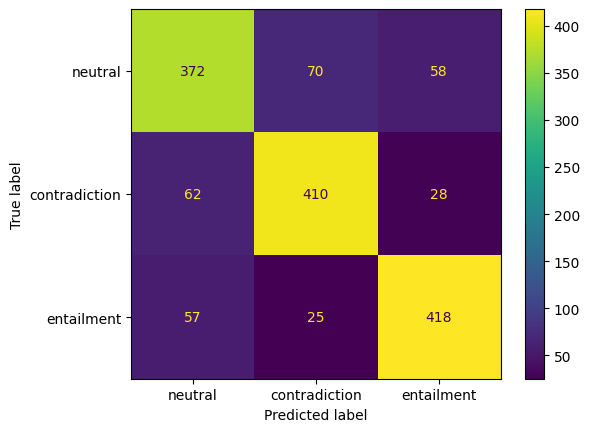

In [ ]:
print("\nStarting model training...")
trainer.train()
trainer.save_model("/content/drive/MyDrive/experiments_data/model_outputs/distilbert_snli_baseline/final_baseline_saved_model")
print("\nModel saved successfully.")

print("\nEvaluating on the test set...")
predictions, labels, _ = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions, axis=1)

print("\nClassification Report (Test Set):")
print(classification_report(labels, pred_labels, target_names=["neutral", "contradiction", "entailment"]))

cf_matrix = confusion_matrix(labels, pred_labels)
print("\nConfusion Matrix (Test Set):")
print(cf_matrix)
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["neutral", "contradiction", "entailment"]).plot()
